In [ ]:
!pip install gymnasium
!pip install stable-baselines3==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import gym
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import matplotlib.animation as animation

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
print("Gym version:", gym.__version__)

Gym version: 0.25.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
class CustomMountainCarContinuous(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.prev_position = None  # Initialize previous position

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)

        # Your existing energy cost calculation
        m = 1.0  # Vehicle mass
        g = 9.81  # Acceleration due to gravity
        theta = np.arctan(3 * next_state[0])  # Road gradient
        Cd = 0.3  # Drag coefficient
        A = 2.0  # Vehicle frontal area
        rho = 1.2  # Air density
        Cr = 0.02  # Rolling resistance coefficient
        velocity = next_state[1]
        F_gravity = m * g * np.sin(theta)
        F_drag = 0.5 * Cd * A * rho * velocity**2
        F_rolling = m * g * Cr * np.cos(theta)
        P = (F_gravity + F_drag + F_rolling) * velocity
        action_scalar = action.item() if isinstance(action, np.ndarray) else action
        energy_cost = P * np.abs(action_scalar)
        reward -= energy_cost

        # Add reward for moving closer to the goal
        goal_position = 0.5  # Modify as needed
        if self.prev_position is not None:
            # Increase reward if moving closer to the goal
            if np.abs(next_state[0] - goal_position) < np.abs(self.prev_position - goal_position):
                reward += 0.1  # Modify as needed
        self.prev_position = next_state[0]

        return next_state, reward, done, info

In [ ]:
class ActionMonitor(Monitor):
    def __init__(self, env, filename):
        super().__init__(env, filename)
        self.action_sum = 0
        self.action_sums = []

    def reset(self, **kwargs):
        self.action_sum = 0
        return super().reset(**kwargs)

    def step(self, action):
        observation, reward, done, info = super().step(action)
        self.action_sum += np.sum(np.abs(action))
        if done:
            self.action_sums.append(self.action_sum)
        return observation, reward, done, info

In [ ]:
import os
# Ensure the log directory exists
if not os.path.exists('./logs/'):
    os.makedirs('./logs/')

In [ ]:
env = ActionMonitor(CustomMountainCarContinuous(gym.make('MountainCarContinuous-v0')), filename="./logs/MountainCarContinuous-v0_1.monitor.csv")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Initialize agent
model = PPO(
    'MlpPolicy',
    env,
    verbose=1,
    learning_rate=0.001,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_sde=False,
    sde_sample_freq=-1,
    target_kl=None,
    tensorboard_log=None,
    create_eval_env=False,
    policy_kwargs=None,
    seed=None,
    device='auto',
    _init_setup_model=True,
)





Using cuda device
Wrapping the env in a DummyVecEnv.


PPO is not very sensitive to hyperparemeters. We have tried different hyperparameter setting but the results did not vary significantly.

In [ ]:
# Add callbacks for early stopping and checkpointing
eval_callback = EvalCallback(env, best_model_save_path='./models/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./checkpoints/',
                                         name_prefix='mountain')

In [ ]:
# Train agent
model.learn(total_timesteps=400000, callback=[eval_callback, checkpoint_callback])

# Save trained agent
model.save("ppo_ev_control_400000")

Streaming output truncated to the last 5000 lines.
|    mean_reward          | 132         |
| rollout/                |             |
|    ep_len_mean          | 430         |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 46          |
|    time_elapsed         | 852         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.006795411 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.14        |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.001       |
|    loss                 | 5.76        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00106    |
|    std                  | 0.209       |
|    value_loss           | 18.5        |
-----------------------------------------
Eval num_timesteps=94500,

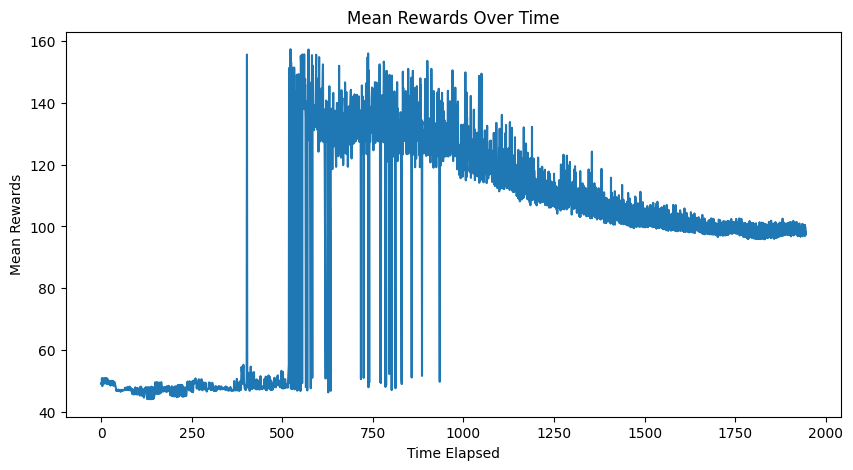

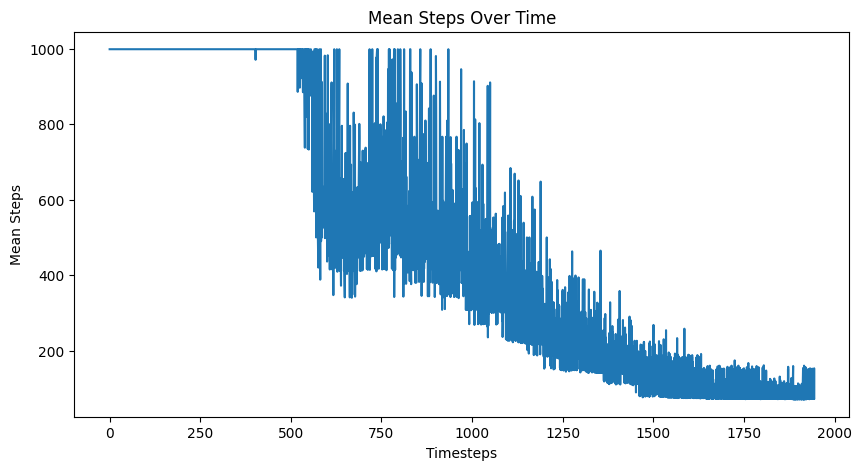

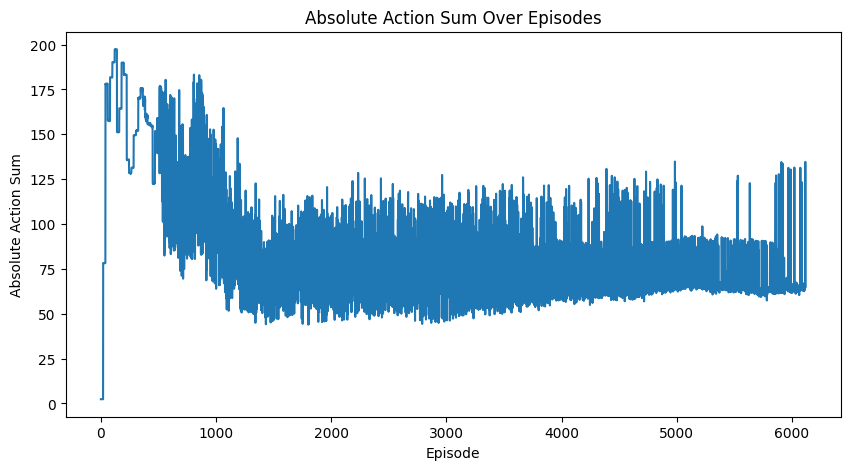

In [ ]:
# Load the training log data
log_df = pd.read_csv('/content/logs/MountainCarContinuous-v0_1.monitor.csv', skiprows=1)

# Process the timestamp data
log_df['t'] -= log_df['t'].iloc[0]

# Plot Mean Rewards
plt.figure(figsize=(10,5))
plt.plot(log_df['t'], log_df['r'])
plt.title('Mean Rewards Over Time')
plt.xlabel('Time Elapsed')
plt.ylabel('Mean Rewards')
plt.show()

# Plot Mean Steps
plt.figure(figsize=(10,5))
plt.plot(log_df['t'], log_df['l'])
plt.title('Mean Steps Over Time')
plt.xlabel('Timesteps')
plt.ylabel('Mean Steps')
plt.show()

# Access action sums
action_sums = env.action_sums

# Plot action sums
plt.figure(figsize=(10,5))
plt.plot(action_sums)
plt.title('Absolute Action Sum Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Absolute Action Sum')
plt.show()

Somehow the reward is decreasing over time, here are some assumptions:
1. The agent might be learning to be more energy-efficient, which could lead to a reduction in the energy cost over time. However, this could also mean that the agent is making slower progress towards the goal, which could lead to a lower progress reward. If the reduction in the energy cost is greater than the increase in the progress reward, the total reward could decrease over time.

2. The agent might be exploring different strategies to solve the task. During this exploration process, the agent might sometimes take actions that lead to lower rewards. This is a normal part of the learning process in reinforcement learning.

3. The environment might be stochastic, meaning that there is some randomness in how the state of the environment changes in response to the agent's actions. This could lead to variability in the rewards over time.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Run the trained agent on the environment
obs = env.reset()
frames = []  # to store the frames
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, terminated, info = env.step(action)
    frames.append(env.render(mode="rgb_array"))  # capture the frame
    if terminated:
        obs = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


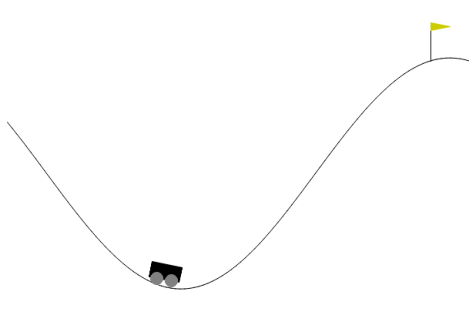

In [ ]:
# Create an animation
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
ani.save('animation.gif', writer='imagemagick')